In [ ]:
import torch

if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("GPU not available, using CPU")

Using GPU: NVIDIA A100-SXM4-40GB


In [ ]:
import pandas as pd

from google.colab import drive

drive.mount('/content/drive')




KeyboardInterrupt: 

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4353508.16it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 123511.06it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:06<00:00, 236390.34it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5634584.08it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Train Epoch: 0 	Model: 0 	Training Loss: 1115.4642280273438 	Temperature Strategy: fixed 	tau_1: 0.5 	tau_2: 0.5
Train Epoch: 0 	Model: 1 	Training Loss: 911.8997430013021 	Temperature Strategy: fixed 	tau_1: 1.0 	tau_2: 1.0
Train Epoch: 0 	Model: 2 	Training Loss: 826.9689458007813 	Temperature Strategy: linear_increase 	tau_1: 1.5 	tau_2: 1.5
Train Epoch: 0 	Model: 3 	Training Loss: 915.5991889648437 	Temperature Strategy: linear_decrease 	tau_1: 0.9959999918937683 	tau_2: 0.9959999918937683
Train Epoch: 0 	Model: 4 	Training Loss: 910.7298115234375 	Temperature Strategy: exp_increase 	tau_1: 1.0099999904632568 	tau_2: 1.0099999904632568
Train Epoch: 0 	Model: 5 	Training Loss: 917.0456829427084 	Temperature Strategy: exp_decrease 	tau_1: 0.9980000257492065 	tau_2: 0.9980000257492065
Train Epoch: 0 	Model: 6 	Training Loss: 876.6270439453125 	Temperature Strategy: fixed 	tau_1: 3.5 	tau_2: 3.5
Train Epoch: 0 	

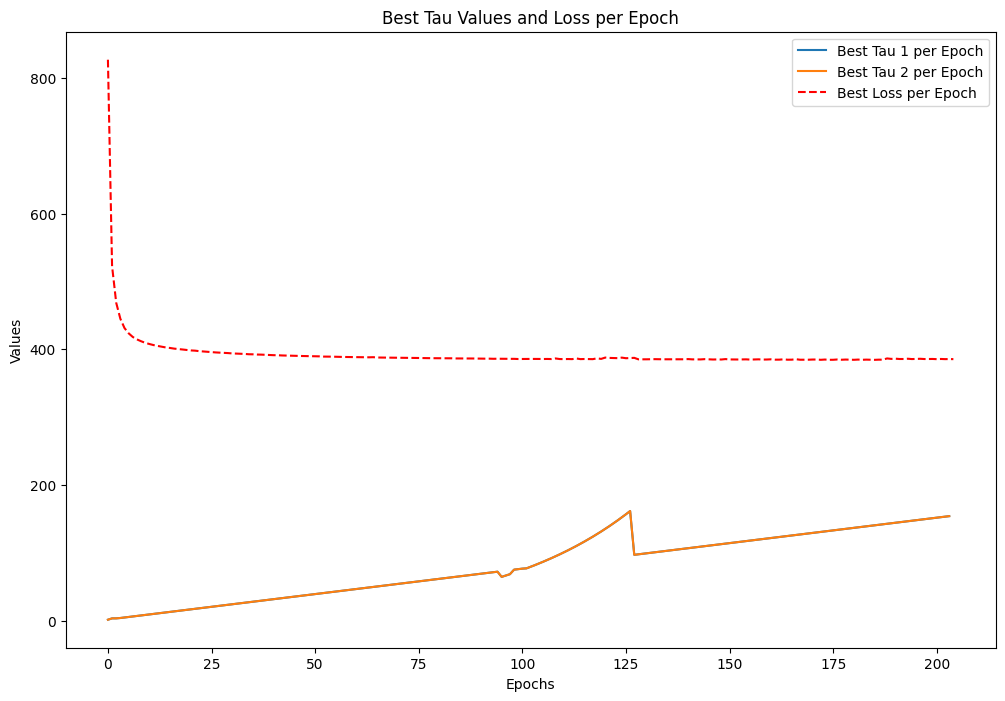

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import copy
import numpy as np
import os
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import CelebA
from torch import optim
from torch.utils import data as dataloader



# Set the random seed and device
SEED = 1
torch.manual_seed(SEED)
cuda = torch.cuda.is_available()
device = torch.device('cuda' if cuda else 'cpu')
SAVE_PATH = "/content/sample_data/best_model_mnist_parallel_desktop2070_August_16.pth"
BATCH_SIZE = 128
Z_DIM = 300
LOG_INTERVAL = 50

# Define the transform for image preprocessing
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST('./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST('./data', train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)

# Remove digits 2 and 3 from the training dataset
train_dataset.data = train_dataset.data[(train_dataset.targets != 2) & (train_dataset.targets != 3)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets != 2) & (train_dataset.targets != 3)]

# Create new data loaders after removing digits 2 and 3
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)


def plot_images(original_images, reconstructed_images, n=10):
    original_images = original_images.cpu().numpy().squeeze()
    reconstructed_images = reconstructed_images.cpu().detach().numpy().squeeze()

    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_images[i], cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed_images[i], cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


# Define the GumbelSoftmaxVAE model
class GumbelSoftmaxVAE(nn.Module):
    def __init__(self, tau_1=1.0, tau_2=1.0):
        super().__init__()

        self.tau_1 = tau_1
        self.tau_2 = tau_2

        # Encoder
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)

        # Two layers of latent variables
        self.fc_logits_z1 = nn.Linear(256 * 4 * 4, Z_DIM)
        self.fc_logits_z2 = nn.Linear(Z_DIM, Z_DIM)

        # Decoder for each layer
        self.fc_dec1 = nn.Linear(Z_DIM, 256 * 4 * 4)
        self.fc_dec2 = nn.Linear(Z_DIM, 128 * 8 * 8)

        self.conv_trans1_1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.conv_trans2_1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.conv_trans3_1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.conv_trans4_1 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)

        self.conv_trans1_2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.conv_trans2_2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.conv_trans3_2 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)

    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(x.size(0), -1)

        logits_z1 = self.fc_logits_z1(x)
        logits_z2 = self.fc_logits_z2(logits_z1)

        return logits_z1, logits_z2

    def reparameterize(self, logits, tau):
        gumbel_noise = torch.rand_like(logits).to(device)
        gumbel_noise = -torch.log(-torch.log(gumbel_noise + 1e-8) + 1e-8)
        z = (logits + gumbel_noise) / tau
        z = F.softmax(z, dim=-1)
        return z


    def decode1(self, z):
        z = self.fc_dec1(z)
        z = z.view(z.size(0), 256, 4, 4)  # reshape
        z = F.relu(self.conv_trans1_1(z))
        z = F.relu(self.conv_trans2_1(z))
        z = F.relu(self.conv_trans3_1(z))
        z = torch.tanh(self.conv_trans4_1(z))
        z = torch.clamp(z, 0, 1)  # Clamp the values between 0 and 1
        return z

    def decode2(self, z):
        z = self.fc_dec2(z)
        z = z.view(z.size(0), 128, 8, 8)  # reshape
        z = F.relu(self.conv_trans1_2(z))
        z = F.relu(self.conv_trans2_2(z))
        z = torch.sigmoid(self.conv_trans3_2(z))
        z = torch.clamp(z, 0, 1)  # Clamp the values between 0 and 1
        return z

    def forward(self, x):
        logits_z1, logits_z2 = self.encode(x)
        z1 = self.reparameterize(logits_z1, self.tau_1)
        z2 = self.reparameterize(logits_z2, self.tau_2)

        x_hat1 = self.decode1(z1)
        x_hat2 = self.decode2(z2)

        # Average the output of the two decoders
        x_hat = (x_hat1 + x_hat2) / 2.0

        return x_hat, logits_z1, logits_z2, z1, z2

    def gumbel_softmax_loss_function(self, recon_x, x, logits_z1, logits_z2, z1, z2):
        # Clamp the values of recon_x between 0 and 1
        recon_x = torch.clamp(recon_x, 0, 1)
        # Binary cross entropy
        xent_loss = F.binary_cross_entropy(recon_x, x, reduction='none')
        xent_loss = torch.sum(xent_loss, dim=[1, 2, 3])

        # KL divergence for each layer
        p_z1 = F.softmax(logits_z1, dim=-1)
        p_z1 = torch.clamp(p_z1, torch.finfo(p_z1.dtype).eps, 1. - torch.finfo(p_z1.dtype).eps)  # to prevent log(0)
        kl_loss_z1 = torch.sum(p_z1 * torch.log(p_z1 * Z_DIM + torch.finfo(p_z1.dtype).eps), dim=-1)

        p_z2 = F.softmax(logits_z2, dim=-1)
        p_z2 = torch.clamp(p_z2, torch.finfo(p_z2.dtype).eps, 1. - torch.finfo(p_z2.dtype).eps)  # to prevent log(0)
        kl_loss_z2 = torch.sum(p_z2 * torch.log(p_z2 * Z_DIM + torch.finfo(p_z2.dtype).eps), dim=-1)

        # Total loss is the sum of the losses for each layer
        vae_loss = torch.mean(xent_loss + kl_loss_z1 + kl_loss_z2)
        return vae_loss


initial_tau_1 = 1.0
initial_tau_2 = 1.0
NUM_EPOCHS = 1000
LOG_INTERVAL = 50
NUM_MODELS = 11
LOSS_THRESHOLD = 0.0001
EARLY_STOP_PATIENCE = 20  # Early stopping patience
initial_taus = [initial_tau_1, initial_tau_2]

models = [GumbelSoftmaxVAE().to(device) for _ in range(NUM_MODELS)]
optimizers = [optim.Adam(model.parameters(), lr=1e-3) for model in models]

temp_strategies = ['fixed', 'linear_increase', 'linear_decrease', 'exp_increase', 'exp_decrease']
temp_strategies_extended = ['fixed'] + temp_strategies * ((NUM_MODELS - 1) // len(temp_strategies)) + temp_strategies[:((NUM_MODELS - 1) % len(temp_strategies))]
tau_min, tau_max = 0.00001, 900000

num_fixed = temp_strategies_extended.count('fixed')
num_linear_increase = temp_strategies_extended.count('linear_increase')
num_linear_decrease = temp_strategies_extended.count('linear_decrease')
num_exp_increase = temp_strategies_extended.count('exp_increase')
num_exp_decrease = temp_strategies_extended.count('exp_decrease')

lin_increase_values = [0.5 + i * 0.25 for i in range(num_linear_increase)]
lin_decrease_values = [0.002 * (2 ** i) for i in range(num_linear_decrease)]
exp_increase_values = [1.01 + i * 0.02 for i in range(num_exp_increase)]
exp_decrease_values = [0.999 - i * 0.001 for i in range(num_exp_decrease)]

taus_1 = []
taus_2 = []

best_tau_per_epoch_1 = []
best_tau_per_epoch_2 = []
best_losses_per_epoch = []

for i in range(NUM_MODELS):
    temp_strategy = temp_strategies_extended[i]

    if temp_strategy == 'fixed':

        tau = torch.tensor(float(0.5 * (i + 1)), requires_grad=True).to(device)
    else:

        tau = torch.tensor(1.0, requires_grad=True).to(device)

    taus_1.append(tau)
    taus_2.append(tau)


assert len(temp_strategies_extended) == NUM_MODELS, f"Expected {NUM_MODELS} strategies, got {len(temp_strategies_extended)}"

best_global_loss = float('inf')
early_stop_counter = 0
learning_rate = 0.01
patience_threshold = 3
patience_counter = [0 for _ in range(NUM_MODELS)]


for epoch in range(NUM_EPOCHS):
    losses = []
    best_reconstruction = None
    original_images = None

    for i in range(NUM_MODELS):
        temp_strategy = temp_strategies_extended[i]
        if temp_strategy == 'linear_increase':
            lin_increase = lin_increase_values[i % len(lin_increase_values)]
            taus_1[i] = torch.tensor(float(min(taus_1[i].item() + lin_increase, tau_max)), requires_grad=True).to(device)
            taus_2[i] = torch.tensor(float(min(taus_2[i].item() + lin_increase, tau_max)), requires_grad=True).to(device)
        elif temp_strategy == 'linear_decrease':
            lin_decrease = lin_decrease_values[i % len(lin_decrease_values)]
            taus_1[i] = torch.tensor(float(max(taus_1[i].item() - lin_decrease, tau_min)), requires_grad=True).to(device)
            taus_2[i] = torch.tensor(float(max(taus_2[i].item() - lin_decrease, tau_min)), requires_grad=True).to(device)
        elif temp_strategy == 'exp_increase':
            exp_increase = exp_increase_values[i % len(exp_increase_values)]
            taus_1[i] = torch.tensor(float(min(taus_1[i].item() * exp_increase, tau_max)), requires_grad=True).to(device)
            taus_2[i] = torch.tensor(float(min(taus_2[i].item() * exp_increase, tau_max)), requires_grad=True).to(device)
        elif temp_strategy == 'exp_decrease':
            exp_decrease = exp_decrease_values[i % len(exp_decrease_values)]
            taus_1[i] = torch.tensor(float(max(taus_1[i].item() * exp_decrease, tau_min)), requires_grad=True).to(device)
            taus_2[i] = torch.tensor(float(max(taus_2[i].item() * exp_decrease, tau_min)), requires_grad=True).to(device)

        models[i].tau_1 = taus_1[i]
        models[i].tau_2 = taus_2[i]

    for i in range(NUM_MODELS):
        model = models[i]
        epoch_loss = 0.0

        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizers[i].zero_grad()
            recon_batch, logits_z1, logits_z2, z1, z2 = model(data)
            loss = model.gumbel_softmax_loss_function(recon_batch, data, logits_z1, logits_z2, z1, z2)
            loss.backward()
            optimizers[i].step()
            epoch_loss += loss.item()

            if epoch_loss < LOSS_THRESHOLD and (best_reconstruction is None or loss.item() < min(losses)):
                best_reconstruction = recon_batch
                original_images = data

        epoch_loss /= len(train_loader)
        losses.append(epoch_loss)
        print(f'Train Epoch: {epoch} \tModel: {i} \tTraining Loss: {epoch_loss} \tTemperature Strategy: {temp_strategies_extended[i]} \ttau_1: {models[i].tau_1.item()} \ttau_2: {models[i].tau_2.item()}')

    best_model_idx = np.argmin(losses)
    best_loss = losses[best_model_idx]
    best_losses_per_epoch.append(best_loss)


    if best_loss < best_global_loss:
        best_global_loss = best_loss
        best_model_state_dict = copy.deepcopy(models[best_model_idx].state_dict())
        torch.save(models[best_model_idx].state_dict(), SAVE_PATH)
        print(f'Best model saved with index: {best_model_idx} and loss: {best_loss}')
        early_stop_counter = 0

    for i in range(NUM_MODELS):
        if i != best_model_idx:
            models[i].load_state_dict(best_model_state_dict, strict=False)

    for i in range(NUM_MODELS):
        if i != best_model_idx:
            if losses[i] > best_loss:
                patience_counter[i] += 1
                if patience_counter[i] >= patience_threshold:
                    delta_tau = learning_rate * (losses[i] - best_loss)
                    print(delta_tau)
                    taus_1[i] = torch.tensor(float(min(taus_1[i].item() + delta_tau, tau_max)), requires_grad=True).to(device)
                    taus_2[i] = torch.tensor(float(min(taus_2[i].item() + delta_tau, tau_max)), requires_grad=True).to(device)
                    models[i].tau_1 = taus_1[i]
                    models[i].tau_2 = taus_2[i]
                    patience_counter[i] = 0
            else:
                patience_counter[i] = 0

    early_stop_counter += 1


    if early_stop_counter >= EARLY_STOP_PATIENCE:
        print(f'Early stopping triggered after {epoch + 1} epochs.')
        break

    best_tau_per_epoch_1.append(models[best_model_idx].tau_1.item())
    best_tau_per_epoch_2.append(models[best_model_idx].tau_2.item())

    print(f'Epoch: {epoch} \tBest Model Index: {best_model_idx} \tBest Temperature Strategy: {temp_strategies_extended[best_model_idx]} \tBest tau_1: {models[best_model_idx].tau_1.item()} \tBest tau_2: {models[best_model_idx].tau_2.item()}')

    if best_reconstruction is not None and original_images is not None:
        plot_images(original_images.cpu(), best_reconstruction.cpu())

for epoch, (tau_1, tau_2, loss) in enumerate(zip(best_tau_per_epoch_1, best_tau_per_epoch_2, best_losses_per_epoch)):
    print(f"Epoch: {epoch}, Best Tau 1: {tau_1}, Best Tau 2: {tau_2}, Best Loss: {loss}")

plt.figure(figsize=(12, 8))
plt.plot(range(len(best_tau_per_epoch_1)), best_tau_per_epoch_1, label='Best Tau 1 per Epoch')
plt.plot(range(len(best_tau_per_epoch_2)), best_tau_per_epoch_2, label='Best Tau 2 per Epoch')
plt.plot(range(len(best_losses_per_epoch)), best_losses_per_epoch, label='Best Loss per Epoch', linestyle='--', color='red')
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.title('Best Tau Values and Loss per Epoch')
plt.legend()
plt.show()



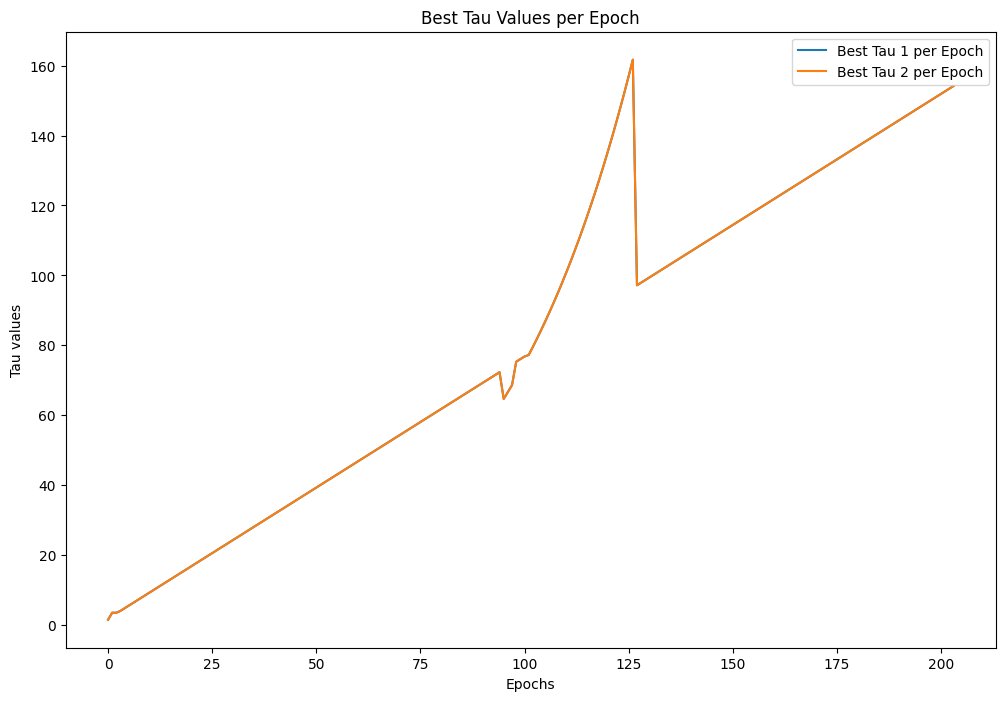

In [ ]:
# Plot the best_tau_per_epoch
plt.figure(figsize=(12, 8))
plt.plot(range(len(best_tau_per_epoch_1)), best_tau_per_epoch_1, label='Best Tau 1 per Epoch')
plt.plot(range(len(best_tau_per_epoch_2)), best_tau_per_epoch_2, label='Best Tau 2 per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Tau values')
plt.title('Best Tau Values per Epoch')
plt.legend()
plt.show()


Average MSE: 0.0003648653241092504
Average SSIM: 0.9927612367479606


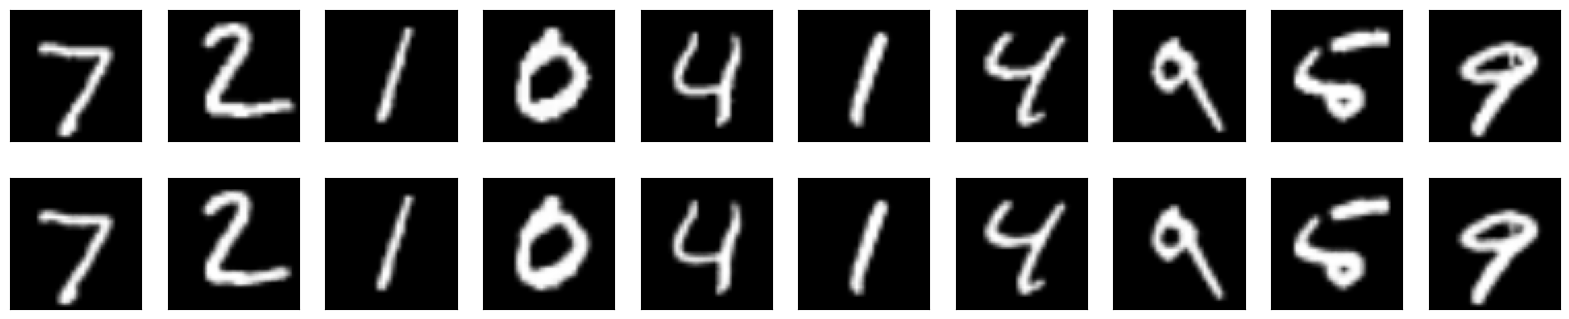

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Define the transform for image preprocessing
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST('./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST('./data', train=False, transform=transform, download=True)

# Create data loaders
BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)

# Remove digits 2 and 3 from the training dataset
train_dataset.data = train_dataset.data[(train_dataset.targets != 2) & (train_dataset.targets != 3)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets != 2) & (train_dataset.targets != 3)]

# Create new data loaders after removing digits 2 and 3
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)

# Function to plot images
def plot_images(original_images, reconstructed_images, n=10):
    original_images = original_images.cpu().numpy()
    reconstructed_images = reconstructed_images.cpu().detach().numpy()

    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed_images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Calculate MSE and SSIM for the entire test dataset
mse_losses = []
ssim_values = []

with torch.no_grad():
    for data, targets in test_loader:
        data = data.to(device)

        # Reconstruct the images
        recon_batch, _, _, _, _ = models[best_model_idx](data)

        # Calculate MSE loss
        mse_loss = F.mse_loss(recon_batch, data)
        mse_losses.append(mse_loss.item())

        # Calculate SSIM
        for i in range(data.size(0)):
            original = data[i].cpu().numpy().transpose(1, 2, 0).squeeze()
            reconstruction = recon_batch[i].cpu().numpy().transpose(1, 2, 0).squeeze()
            ssim_value = ssim(original, reconstruction, data_range=reconstruction.max() - reconstruction.min())
            ssim_values.append(ssim_value)

# Calculate average MSE and SSIM
avg_mse = np.mean(mse_losses)
avg_ssim = np.mean(ssim_values)

print(f'Average MSE: {avg_mse}')
print(f'Average SSIM: {avg_ssim}')

# Choose a random batch of images from the test dataset
data, targets = next(iter(test_loader))
data, targets = data.to(device), targets.to(device)

# Pass the images through the best model
recon_batch, _, _, _, _ = models[best_model_idx](data)

# Plot the original and reconstructed images
plot_images(data.cpu(), recon_batch.cpu())


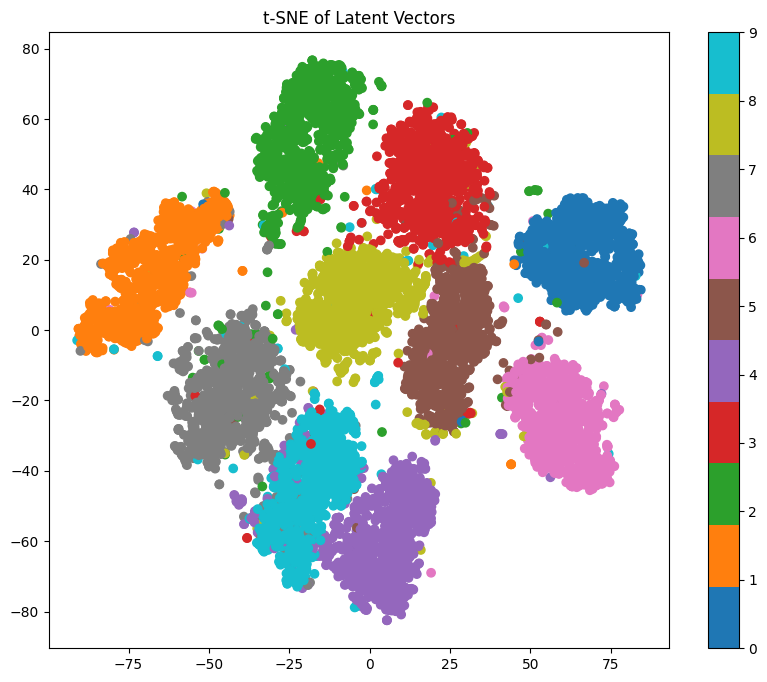

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
batch_size = 128

def get_latent_vectors(model, data):
    with torch.no_grad():
        _, _, _, _, z = model(data)
        return z


all_latent_vectors = []
all_labels = []


for data, labels in test_loader:
    data = data.to(device)
    latent_vectors = get_latent_vectors(models[best_model_idx], data).cpu().detach().numpy()
    all_latent_vectors.append(latent_vectors)
    all_labels.append(labels.numpy())

    if len(all_latent_vectors) * batch_size > 10000:
        break


all_latent_vectors = np.concatenate(all_latent_vectors, axis=0)
all_labels = np.concatenate(all_labels, axis=0)


tsne = TSNE(n_components=2, random_state=0)
all_latent_tsne = tsne.fit_transform(all_latent_vectors)


plt.figure(figsize=(10, 8))
plt.scatter(all_latent_tsne[:, 0], all_latent_tsne[:, 1], c=all_labels, cmap='tab10')
plt.colorbar()
plt.title('t-SNE of Latent Vectors')
plt.show()


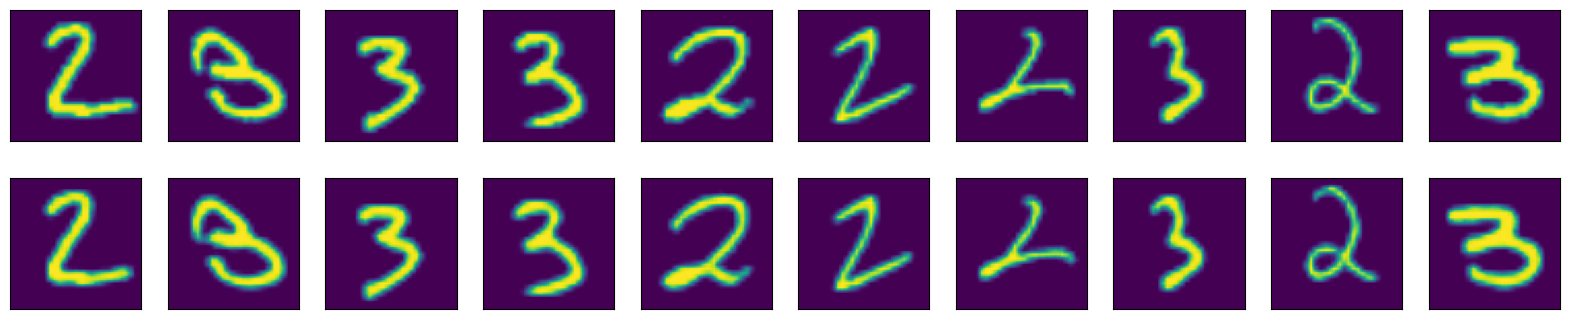

In [ ]:
# Results of my parallel GS-VAEs on MNIST reconstruction of unseen digits (2s and 3s)
def plot_images(original_images, reconstructed_images, n=10):
    original_images = original_images.cpu().numpy()
    reconstructed_images = reconstructed_images.cpu().detach().numpy()

    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_images[i].transpose(1, 2, 0).squeeze())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed_images[i].transpose(1, 2, 0).squeeze())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Function to filter out only the digits 2 and 3
def filter_2_and_3(data, target):
    mask = (target == 2) | (target == 3)
    return data[mask], target[mask]

# Choose a random batch of images from the test dataset
data, targets = next(iter(test_loader))
data, targets = data.to(device), targets.to(device)

# Filter out only the digits 2 and 3
data, targets = filter_2_and_3(data, targets)

# Pass the images through the best model
recon_batch, _, _, _, _ = models[best_model_idx](data)

# Plot the original and reconstructed images
plot_images(data.cpu(), recon_batch.cpu())


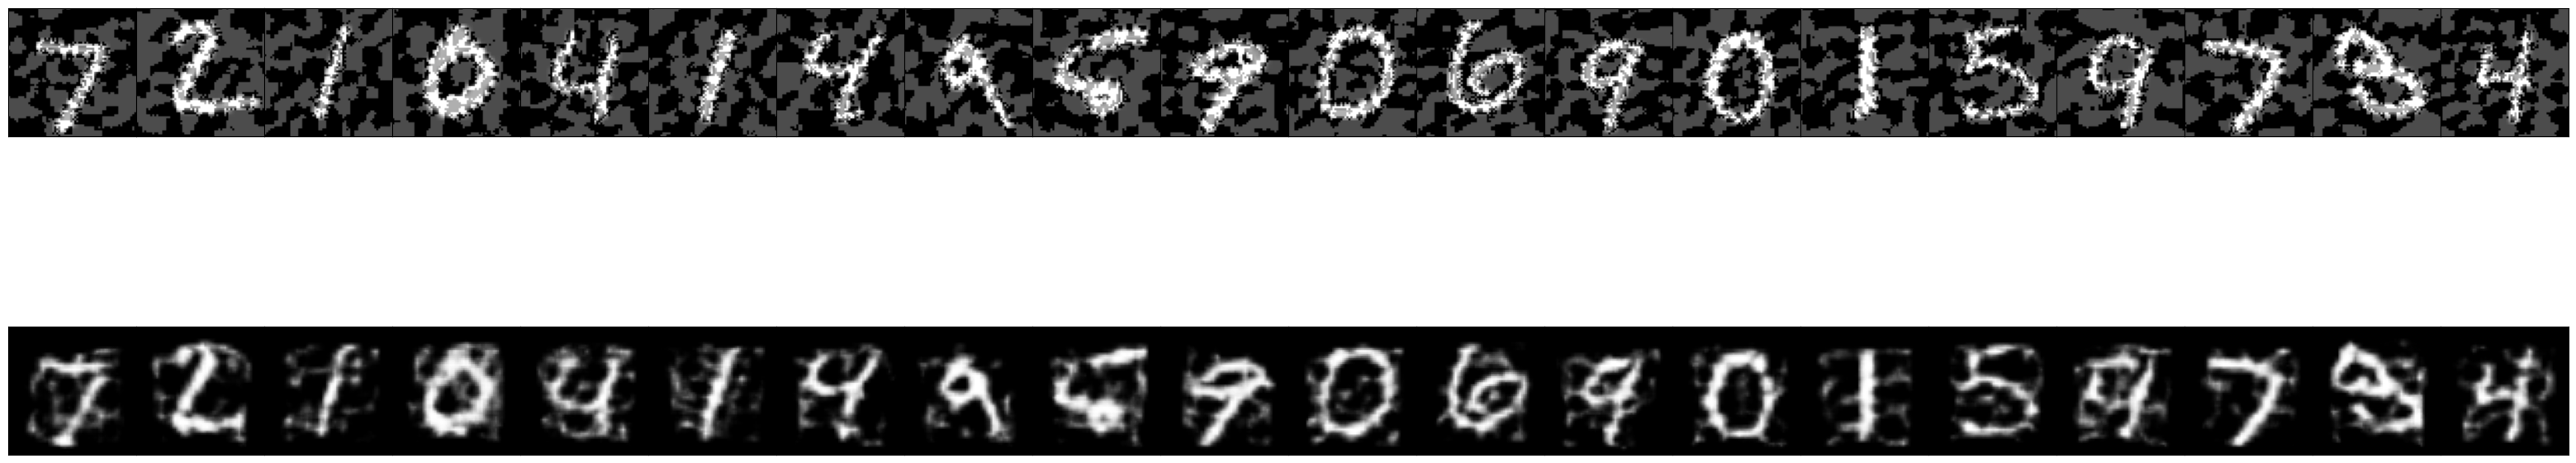

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])


train_dataset = datasets.MNIST('./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST('./data', train=False, transform=transform, download=True)


train_loader = DataLoader(train_dataset, shuffle=True, batch_size=128, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128, num_workers=4, pin_memory=True)


def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

data, targets = next(iter(test_loader))
data, targets = data.to(device), targets.to(device)


epsilon = 0.3

models[best_model_idx].eval()

data.requires_grad = True

reconstructed_images = models[best_model_idx](data)[0]

loss = F.mse_loss(reconstructed_images, data)
models[best_model_idx].zero_grad()
loss.backward()

data_grad = data.grad.data

perturbed_data = fgsm_attack(data, epsilon, data_grad)

recon_batch_model = models[best_model_idx](perturbed_data)[0]


plt.figure(figsize=(40, 10))
for i in range(20):
    ax = plt.subplot(4, 20, i + 1)
    plt.imshow(perturbed_data[i].cpu().detach().numpy().transpose(1, 2, 0).squeeze(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(4, 20, i + 41)
    plt.imshow(recon_batch_model[i].cpu().detach().numpy().transpose(1, 2, 0).squeeze(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.subplots_adjust(wspace=0.00, hspace=0.00)
plt.show()


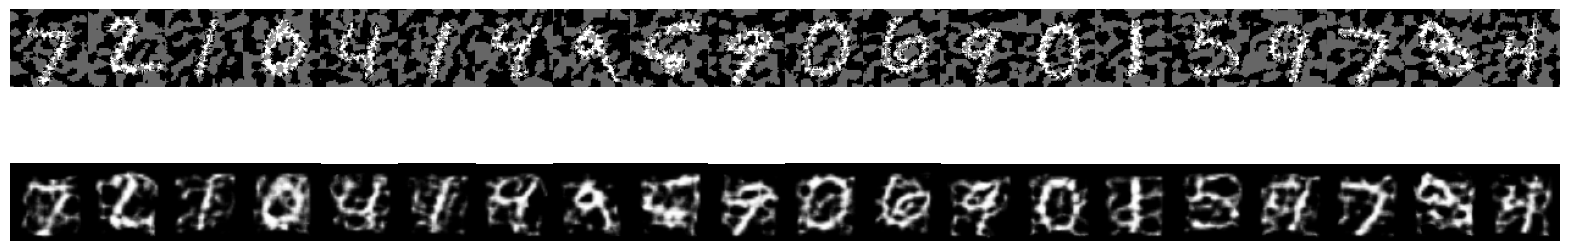

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])


train_dataset = datasets.MNIST('./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST('./data', train=False, transform=transform, download=True)


train_loader = DataLoader(train_dataset, shuffle=True, batch_size=128, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128, num_workers=4, pin_memory=True)


def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

data, targets = next(iter(test_loader))
data, targets = data.to(device), targets.to(device)


epsilon = 0.4

models[best_model_idx].eval()

data.requires_grad = True

reconstructed_images = models[best_model_idx](data)[0]

loss = F.mse_loss(reconstructed_images, data)
models[best_model_idx].zero_grad()
loss.backward()

data_grad = data.grad.data

perturbed_data = fgsm_attack(data, epsilon, data_grad)

recon_batch_model = models[best_model_idx](perturbed_data)[0]


plt.figure(figsize=(20, 4))
for i in range(20):

    ax = plt.subplot(2, 20, i + 1)
    plt.imshow(perturbed_data[i].cpu().detach().numpy().transpose(1, 2, 0).squeeze(), cmap='gray')
    ax.axis('off')

    ax = plt.subplot(2, 20, i + 21)
    plt.imshow(recon_batch_model[i].cpu().detach().numpy().transpose(1, 2, 0).squeeze(), cmap='gray')
    ax.axis('off')

plt.subplots_adjust(wspace=0.00, hspace=0.00)
plt.show()

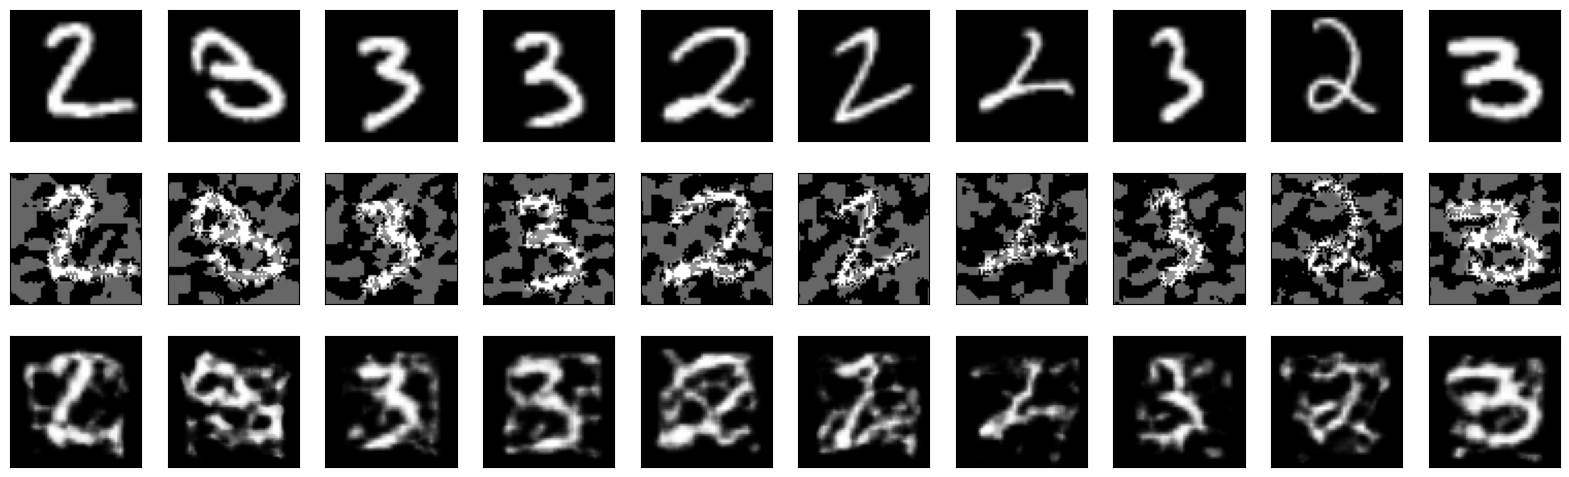

In [ ]:
# Test the models performance for reconstruction under high-intensity FGSM adversarial attacks
# The models were trained by the dataset without 2s and 3s
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define the transform
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Adjust input image size to match the model's expected input size
    transforms.ToTensor()
])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST('./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST('./data', train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=128, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128, num_workers=4, pin_memory=True)

# FGSM attack function
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

# Plot original images, FGSM attacked images, and reconstructed FGSM attacked images
def plot_images(original_images, perturbed_images, reconstructed_images, n=10):
    original_images = original_images.cpu().detach().numpy()
    perturbed_images = perturbed_images.cpu().detach().numpy()
    reconstructed_images = reconstructed_images.cpu().detach().numpy()

    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Display original images
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(original_images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display FGSM attacked images
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(perturbed_images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstructed FGSM attacked images
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(reconstructed_images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Function to filter out only the digits 2 and 3
def filter_2_and_3(data, target):
    mask = (target == 2) | (target == 3)
    return data[mask], target[mask]

# Choose a random batch of images from the test dataset
data, targets = next(iter(test_loader))
data, targets = data.to(device), targets.to(device)

# Filter out only the digits 2 and 3
data, targets = filter_2_and_3(data, targets)

# Set FGSM attack parameters
epsilon = 0.4  # Attack strength

# Need to calculate the gradient of the data
data.requires_grad = True

# Get model predictions on the original data
output, _, _, _, _ = models[best_model_idx](data)
loss = F.mse_loss(output, data)
models[best_model_idx].zero_grad()
loss.backward()

# Generate adversarial samples
data_grad = data.grad.data
perturbed_data = fgsm_attack(data, epsilon, data_grad)

# Reconstruct adversarial samples
recon_batch = models[best_model_idx](perturbed_data)[0]

# Plot original images, FGSM attacked images, and reconstructed FGSM attacked images
plot_images(data, perturbed_data, recon_batch)


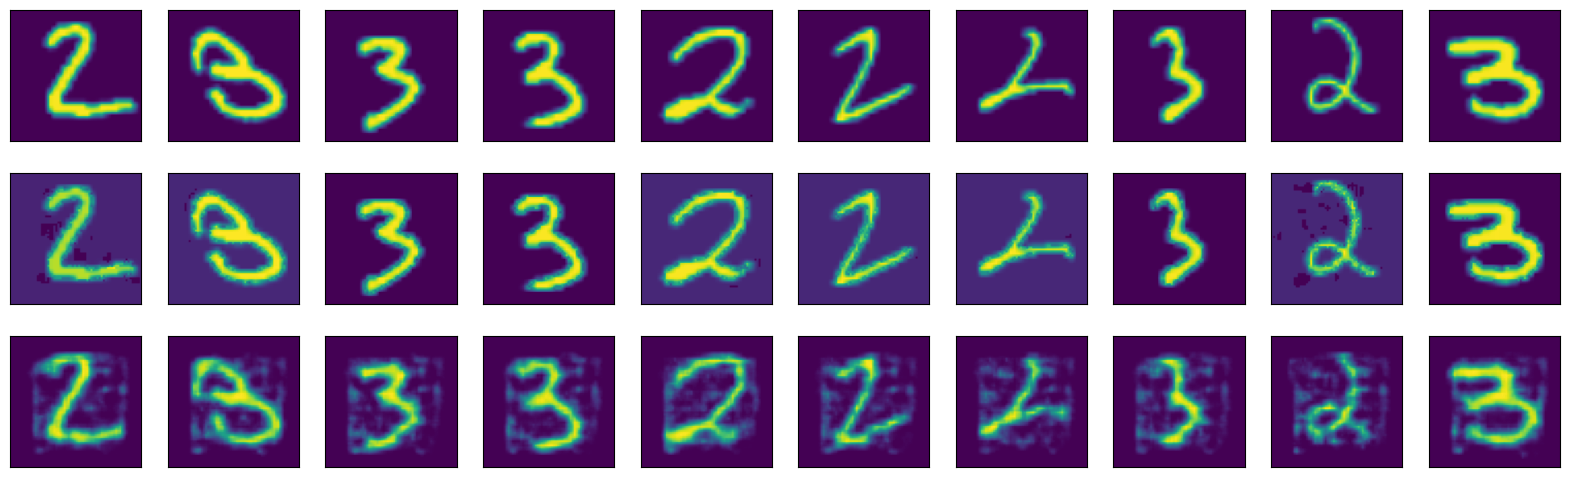

In [ ]:
# Test performance of reconstruction under FGSM attack by using our model
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# FGSM attack function
def fgsm_attack(data, epsilon, gradient):
    sign_data_grad = gradient.sign()
    perturbed_data = data + epsilon * sign_data_grad
    perturbed_data = torch.clamp(perturbed_data, 0, 1)
    return perturbed_data

# Plot original images, FGSM attacked images, and reconstructed FGSM attacked images
def plot_images(original_images, perturbed_images, reconstructed_images, n=10):
    original_images = original_images.cpu().detach().numpy()
    perturbed_images = perturbed_images.cpu().detach().numpy()
    reconstructed_images = reconstructed_images.cpu().detach().numpy()

    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Display original images
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(original_images[i].transpose(1, 2, 0).squeeze())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display FGSM attacked images
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(perturbed_images[i].transpose(1, 2, 0).squeeze())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstructed FGSM attacked images
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(reconstructed_images[i].transpose(1, 2, 0).squeeze())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Function to filter out only the digits 2 and 3
def filter_2_and_3(data, target):
    mask = (target == 2) | (target == 3)
    return data[mask], target[mask]

# Choose a random batch of images from the test dataset
data, targets = next(iter(test_loader))
data, targets = data.to(device), targets.to(device)

# Filter out only the digits 2 and 3
data, targets = filter_2_and_3(data, targets)

# Set FGSM attack parameters
epsilon = 0.1  # Attack strength

# Need to calculate the gradient of the data
data.requires_grad = True

# Get model predictions on the original data
output, _, _, _, _ = models[best_model_idx](data)
loss = F.binary_cross_entropy(output, data)
models[best_model_idx].zero_grad()
loss.backward()

# Generate adversarial samples
data_grad = data.grad.data
perturbed_data = fgsm_attack(data, epsilon, data_grad)

# Reconstruct adversarial samples
recon_batch, _, _, _, _ = models[best_model_idx](perturbed_data)

# Plot original images, FGSM attacked images, and reconstructed FGSM attacked images
plot_images(data.cpu().detach(), perturbed_data.cpu().detach(), recon_batch.cpu().detach())


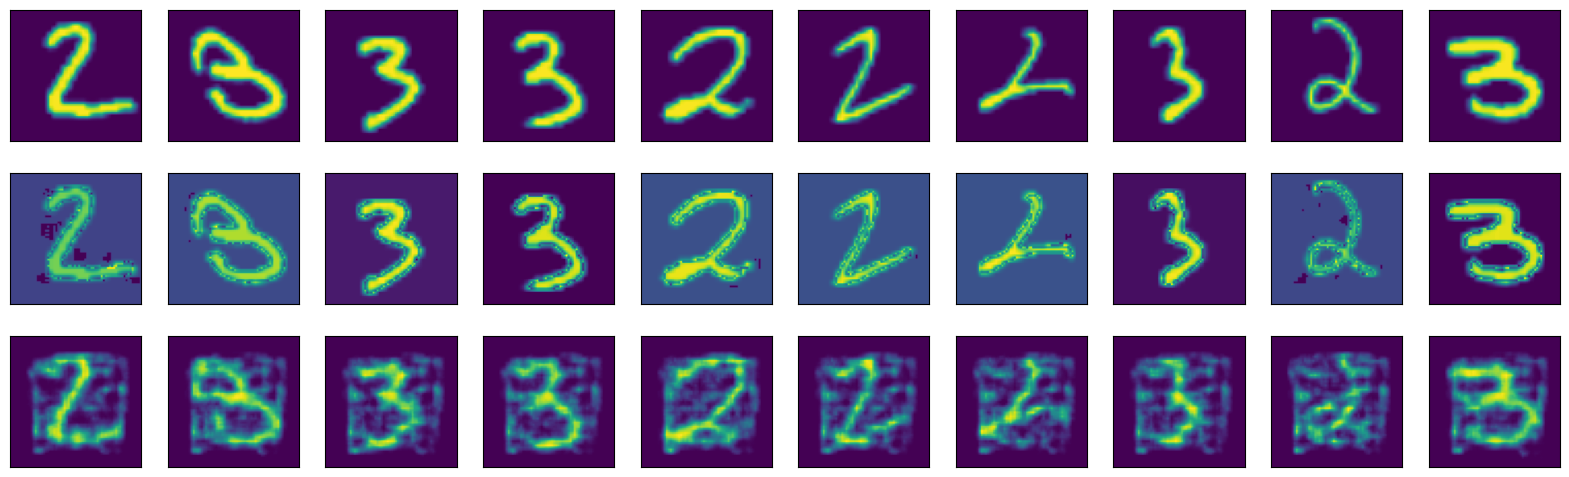

In [ ]:
# Test performance of reconstruction under FGSM attack by using our model
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# FGSM attack function
def fgsm_attack(data, epsilon, gradient):
    sign_data_grad = gradient.sign()
    perturbed_data = data + epsilon * sign_data_grad
    perturbed_data = torch.clamp(perturbed_data, 0, 1)
    return perturbed_data

# Plot original images, FGSM attacked images, and reconstructed FGSM attacked images
def plot_images(original_images, perturbed_images, reconstructed_images, n=10):
    original_images = original_images.cpu().detach().numpy()
    perturbed_images = perturbed_images.cpu().detach().numpy()
    reconstructed_images = reconstructed_images.cpu().detach().numpy()

    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Display original images
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(original_images[i].transpose(1, 2, 0).squeeze())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display FGSM attacked images
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(perturbed_images[i].transpose(1, 2, 0).squeeze())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstructed FGSM attacked images
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(reconstructed_images[i].transpose(1, 2, 0).squeeze())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Function to filter out only the digits 2 and 3
def filter_2_and_3(data, target):
    mask = (target == 2) | (target == 3)
    return data[mask], target[mask]

# Choose a random batch of images from the test dataset
data, targets = next(iter(test_loader))
data, targets = data.to(device), targets.to(device)

# Filter out only the digits 2 and 3
data, targets = filter_2_and_3(data, targets)

# Set FGSM attack parameters
epsilon = 0.2  # Attack strength

# Need to calculate the gradient of the data
data.requires_grad = True

# Get model predictions on the original data
output, _, _, _, _ = models[best_model_idx](data)
loss = F.binary_cross_entropy(output, data)
models[best_model_idx].zero_grad()
loss.backward()

# Generate adversarial samples
data_grad = data.grad.data
perturbed_data = fgsm_attack(data, epsilon, data_grad)

# Reconstruct adversarial samples
recon_batch, _, _, _, _ = models[best_model_idx](perturbed_data)

# Plot original images, FGSM attacked images, and reconstructed FGSM attacked images
plot_images(data.cpu().detach(), perturbed_data.cpu().detach(), recon_batch.cpu().detach())


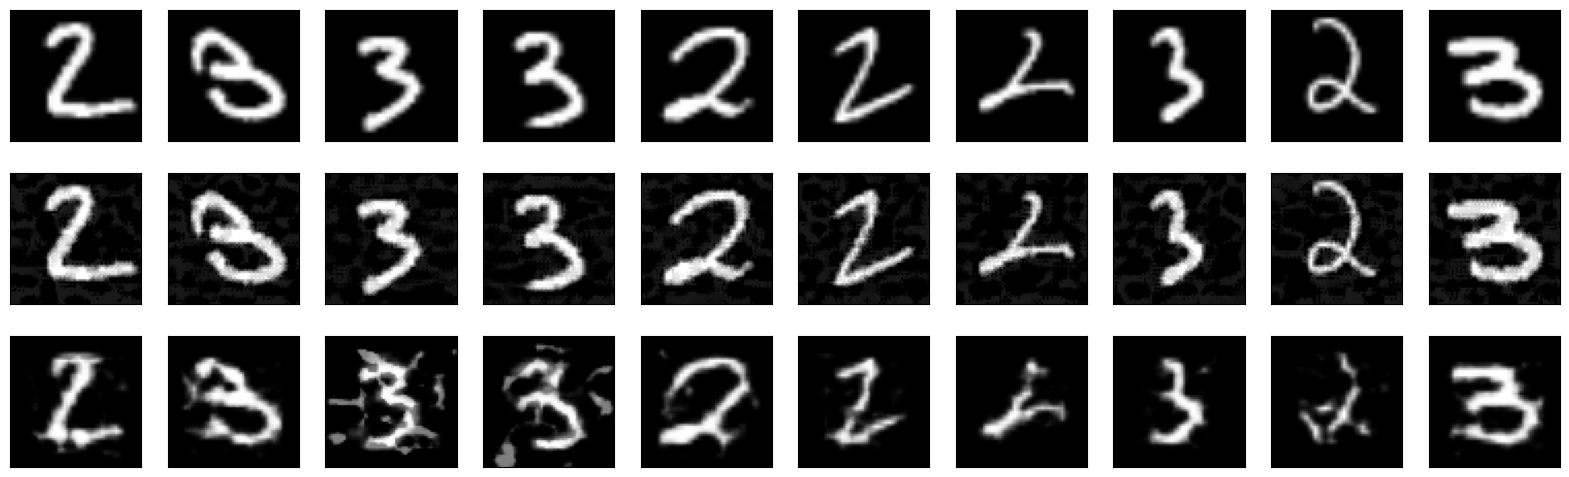

In [ ]:
# Test the models performance for reconstruction under high-intensity PGD adversarial attacks
# The models were trained by the dataset without 2s and 3s
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define the transform
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Adjust input image size to match the model's expected input size
    transforms.ToTensor()
])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST('./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST('./data', train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=128, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128, num_workers=4, pin_memory=True)

# PGD attack function
def pgd_attack(model, images, epsilon, alpha, num_iter):
    images = images.clone().detach().requires_grad_(True).to(device)
    for _ in range(num_iter):
        output, _, _, _, _ = model(images)
        loss = F.mse_loss(output, images)
        model.zero_grad()
        loss.backward()
        with torch.no_grad():
            perturbed_images = images + alpha * images.grad.sign()
            perturbed_images = torch.clamp(perturbed_images, 0, 1)
            perturbed_images = torch.max(torch.min(perturbed_images, images + epsilon), images - epsilon)
            images = perturbed_images.detach().requires_grad_(True)
    return images

# Plot original images, PGD attacked images, and reconstructed PGD attacked images
def plot_images(original_images, perturbed_images, reconstructed_images, n=10):
    original_images = original_images.cpu().detach().numpy()
    perturbed_images = perturbed_images.cpu().detach().numpy()
    reconstructed_images = reconstructed_images.cpu().detach().numpy()

    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Display original images
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(original_images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display PGD attacked images
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(perturbed_images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstructed PGD attacked images
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(reconstructed_images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Function to filter out only the digits 2 and 3
def filter_2_and_3(data, target):
    mask = (target == 2) | (target == 3)
    return data[mask], target[mask]

# Choose a random batch of images from the test dataset
data, targets = next(iter(test_loader))
data, targets = data.to(device), targets.to(device)

# Filter out only the digits 2 and 3
data, targets = filter_2_and_3(data, targets)

# Set PGD attack parameters
epsilon = 0.5  # Maximum perturbation
alpha = 0.01   # Step size, increased to make attack stronger
num_iter = 10  # Number of iterations

# Generate adversarial samples using PGD
perturbed_data = pgd_attack(models[best_model_idx], data, epsilon, alpha, num_iter)

# Reconstruct adversarial samples
recon_batch = models[best_model_idx](perturbed_data)[0]

# Plot original images, PGD attacked images, and reconstructed PGD attacked images
plot_images(data, perturbed_data, recon_batch)


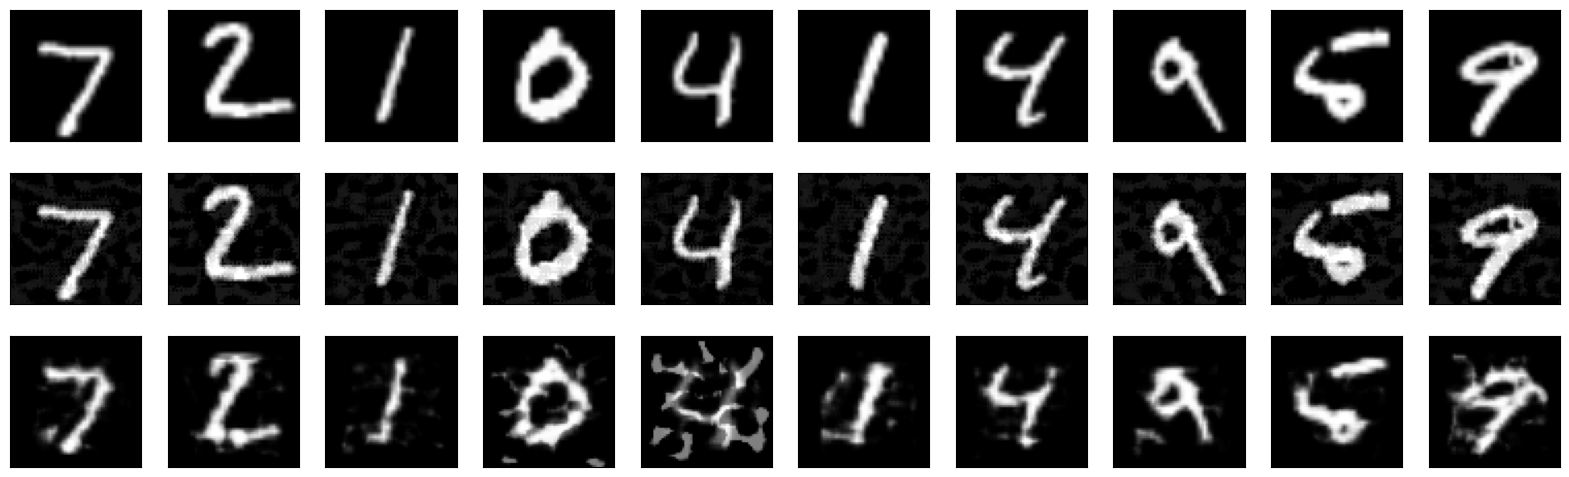

In [ ]:
# Test the models performance for reconstruction under high-intensity PGD adversarial attacks
# The models were trained by the dataset without 2s and 3s
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define the transform
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Adjust input image size to match the model's expected input size
    transforms.ToTensor()
])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST('./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST('./data', train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=128, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128, num_workers=4, pin_memory=True)

# PGD attack function
def pgd_attack(model, images, epsilon, alpha, num_iter):
    images = images.clone().detach().requires_grad_(True).to(device)
    for _ in range(num_iter):
        output, _, _, _, _ = model(images)
        loss = F.mse_loss(output, images)
        model.zero_grad()
        loss.backward()
        with torch.no_grad():
            perturbed_images = images + alpha * images.grad.sign()
            perturbed_images = torch.clamp(perturbed_images, 0, 1)
            perturbed_images = torch.max(torch.min(perturbed_images, images + epsilon), images - epsilon)
            images = perturbed_images.detach().requires_grad_(True)
    return images

# Plot original images, PGD attacked images, and reconstructed PGD attacked images
def plot_images(original_images, perturbed_images, reconstructed_images, n=10):
    original_images = original_images.cpu().detach().numpy()
    perturbed_images = perturbed_images.cpu().detach().numpy()
    reconstructed_images = reconstructed_images.cpu().detach().numpy()

    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Display original images
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(original_images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display PGD attacked images
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(perturbed_images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstructed PGD attacked images
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(reconstructed_images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# # Function to filter out only the digits 2 and 3
# def filter_2_and_3(data, target):
#     mask = (target == 2) | (target == 3)
#     return data[mask], target[mask]

# Choose a random batch of images from the test dataset
data, targets = next(iter(test_loader))
data, targets = data.to(device), targets.to(device)

# # Filter out only the digits 2 and 3
# data, targets = filter_2_and_3(data, targets)

# Set PGD attack parameters
epsilon = 0.5  # Maximum perturbation
alpha = 0.01   # Step size, increased to make attack stronger
num_iter = 10  # Number of iterations

# Generate adversarial samples using PGD
perturbed_data = pgd_attack(models[best_model_idx], data, epsilon, alpha, num_iter)

# Reconstruct adversarial samples
recon_batch = models[best_model_idx](perturbed_data)[0]

# Plot original images, PGD attacked images, and reconstructed PGD attacked images
plot_images(data, perturbed_data, recon_batch)


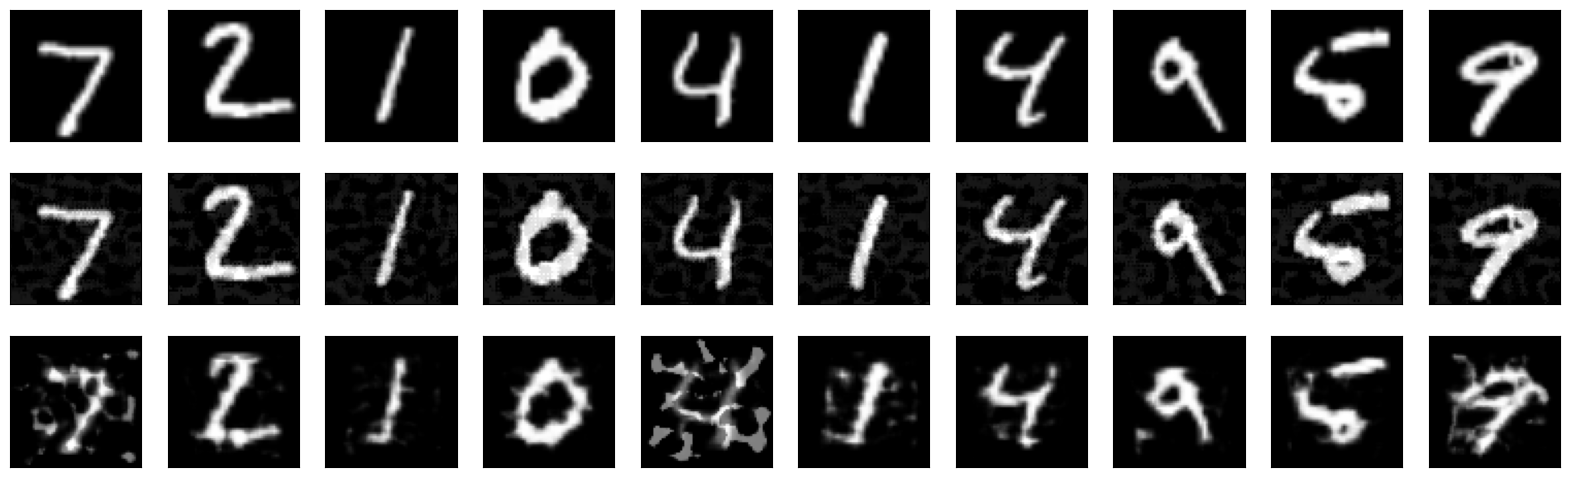

In [ ]:
# Test the models performance for reconstruction under high-intensity PGD adversarial attacks
# The models were trained by the dataset without 2s and 3s
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define the transform
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Adjust input image size to match the model's expected input size
    transforms.ToTensor()
])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST('./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST('./data', train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=128, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128, num_workers=4, pin_memory=True)

# PGD attack function
def pgd_attack(model, images, epsilon, alpha, num_iter):
    images = images.clone().detach().requires_grad_(True).to(device)
    for _ in range(num_iter):
        output, _, _, _, _ = model(images)
        loss = F.mse_loss(output, images)
        model.zero_grad()
        loss.backward()
        with torch.no_grad():
            perturbed_images = images + alpha * images.grad.sign()
            perturbed_images = torch.clamp(perturbed_images, 0, 1)
            perturbed_images = torch.max(torch.min(perturbed_images, images + epsilon), images - epsilon)
            images = perturbed_images.detach().requires_grad_(True)
    return images

# Plot original images, PGD attacked images, and reconstructed PGD attacked images
def plot_images(original_images, perturbed_images, reconstructed_images, n=10):
    original_images = original_images.cpu().detach().numpy()
    perturbed_images = perturbed_images.cpu().detach().numpy()
    reconstructed_images = reconstructed_images.cpu().detach().numpy()

    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Display original images
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(original_images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display PGD attacked images
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(perturbed_images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstructed PGD attacked images
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(reconstructed_images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# # Function to filter out only the digits 2 and 3
# def filter_2_and_3(data, target):
#     mask = (target == 2) | (target == 3)
#     return data[mask], target[mask]

# Choose a random batch of images from the test dataset
data, targets = next(iter(test_loader))
data, targets = data.to(device), targets.to(device)

# # Filter out only the digits 2 and 3
# data, targets = filter_2_and_3(data, targets)

# Set PGD attack parameters
epsilon = 0.3  # Maximum perturbation
alpha = 0.01   # Step size, increased to make attack stronger
num_iter = 10  # Number of iterations

# Generate adversarial samples using PGD
perturbed_data = pgd_attack(models[best_model_idx], data, epsilon, alpha, num_iter)

# Reconstruct adversarial samples
recon_batch = models[best_model_idx](perturbed_data)[0]

# Plot original images, PGD attacked images, and reconstructed PGD attacked images
plot_images(data, perturbed_data, recon_batch)


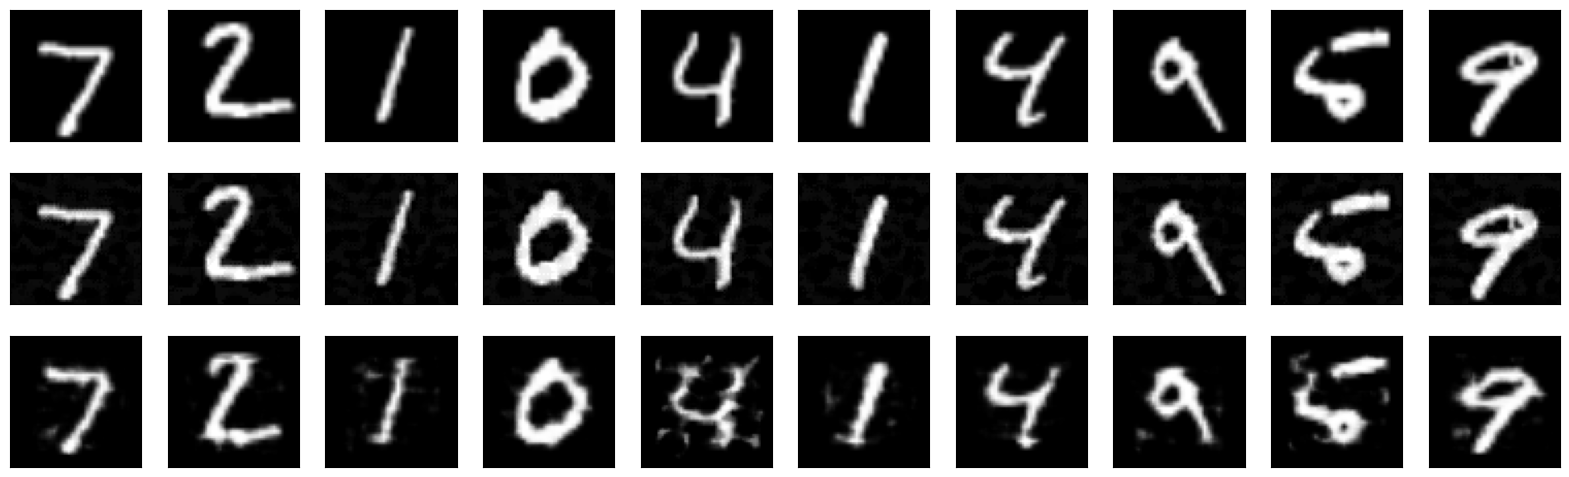

In [ ]:
# Test the models performance for reconstruction under high-intensity PGD adversarial attacks
# The models were trained by the dataset without 2s and 3s
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define the transform
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Adjust input image size to match the model's expected input size
    transforms.ToTensor()
])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST('./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST('./data', train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=128, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128, num_workers=4, pin_memory=True)

# PGD attack function
def pgd_attack(model, images, epsilon, alpha, num_iter):
    images = images.clone().detach().requires_grad_(True).to(device)
    for _ in range(num_iter):
        output, _, _, _, _ = model(images)
        loss = F.mse_loss(output, images)
        model.zero_grad()
        loss.backward()
        with torch.no_grad():
            perturbed_images = images + alpha * images.grad.sign()
            perturbed_images = torch.clamp(perturbed_images, 0, 1)
            perturbed_images = torch.max(torch.min(perturbed_images, images + epsilon), images - epsilon)
            images = perturbed_images.detach().requires_grad_(True)
    return images

# Plot original images, PGD attacked images, and reconstructed PGD attacked images
def plot_images(original_images, perturbed_images, reconstructed_images, n=10):
    original_images = original_images.cpu().detach().numpy()
    perturbed_images = perturbed_images.cpu().detach().numpy()
    reconstructed_images = reconstructed_images.cpu().detach().numpy()

    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Display original images
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(original_images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display PGD attacked images
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(perturbed_images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstructed PGD attacked images
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(reconstructed_images[i].transpose(1, 2, 0).squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# # Function to filter out only the digits 2 and 3
# def filter_2_and_3(data, target):
#     mask = (target == 2) | (target == 3)
#     return data[mask], target[mask]

# Choose a random batch of images from the test dataset
data, targets = next(iter(test_loader))
data, targets = data.to(device), targets.to(device)

# # Filter out only the digits 2 and 3
# data, targets = filter_2_and_3(data, targets)

# Set PGD attack parameters
epsilon = 0.5  # Maximum perturbation
alpha = 0.01   # Step size, increased to make attack stronger
num_iter = 5  # Number of iterations

# Generate adversarial samples using PGD
perturbed_data = pgd_attack(models[best_model_idx], data, epsilon, alpha, num_iter)

# Reconstruct adversarial samples
recon_batch = models[best_model_idx](perturbed_data)[0]

# Plot original images, PGD attacked images, and reconstructed PGD attacked images
plot_images(data, perturbed_data, recon_batch)


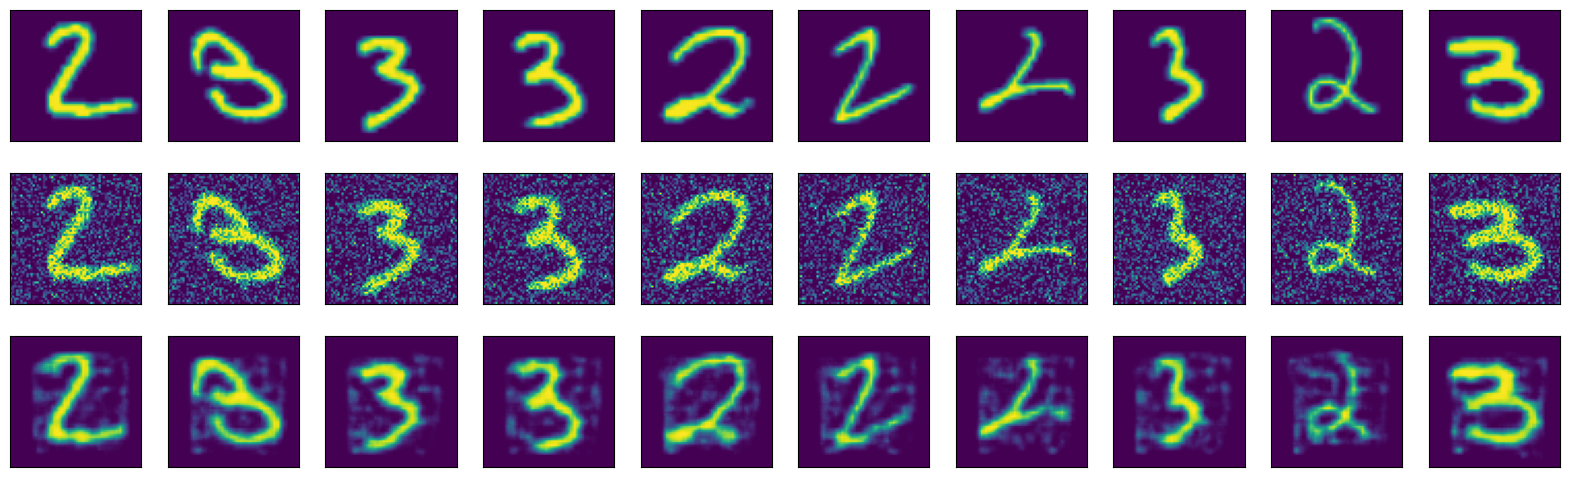

In [ ]:
# Test performance of reconstruction under Gaussian noise attack by using our model
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Gaussian noise attack function
def gaussian_noise_attack(data, std):
    noise = torch.randn_like(data) * std
    perturbed_data = data + noise
    perturbed_data = torch.clamp(perturbed_data, 0, 1)
    return perturbed_data

# Plot original images, Gaussian noise attacked images, and reconstructed Gaussian noise attacked images
def plot_images(original_images, perturbed_images, reconstructed_images, n=10):
    original_images = original_images.cpu().numpy()
    perturbed_images = perturbed_images.cpu().detach().numpy()
    reconstructed_images = reconstructed_images.cpu().detach().numpy()

    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Display original images
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(original_images[i].transpose(1, 2, 0).squeeze())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display Gaussian noise attacked images
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(perturbed_images[i].transpose(1, 2, 0).squeeze())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstructed Gaussian noise attacked images
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(reconstructed_images[i].transpose(1, 2, 0).squeeze())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Function to filter out only the digits 2 and 3
def filter_2_and_3(data, target):
    mask = (target == 2) | (target == 3)
    return data[mask], target[mask]

# Choose a random batch of images from the test dataset
data, targets = next(iter(test_loader))
data, targets = data.to(device), targets.to(device)

# Filter out only the digits 2 and 3
data, targets = filter_2_and_3(data, targets)

# Set Gaussian noise attack parameters
std = 0.3  # Noise standard deviation

# Generate adversarial samples using Gaussian noise
perturbed_data = gaussian_noise_attack(data, std)

# Reconstruct adversarial samples
recon_batch, _, _, _, _ = models[best_model_idx](perturbed_data)

# Plot original images, Gaussian noise attacked images, and reconstructed Gaussian noise attacked images
plot_images(data.cpu(), perturbed_data.cpu(), recon_batch.cpu())


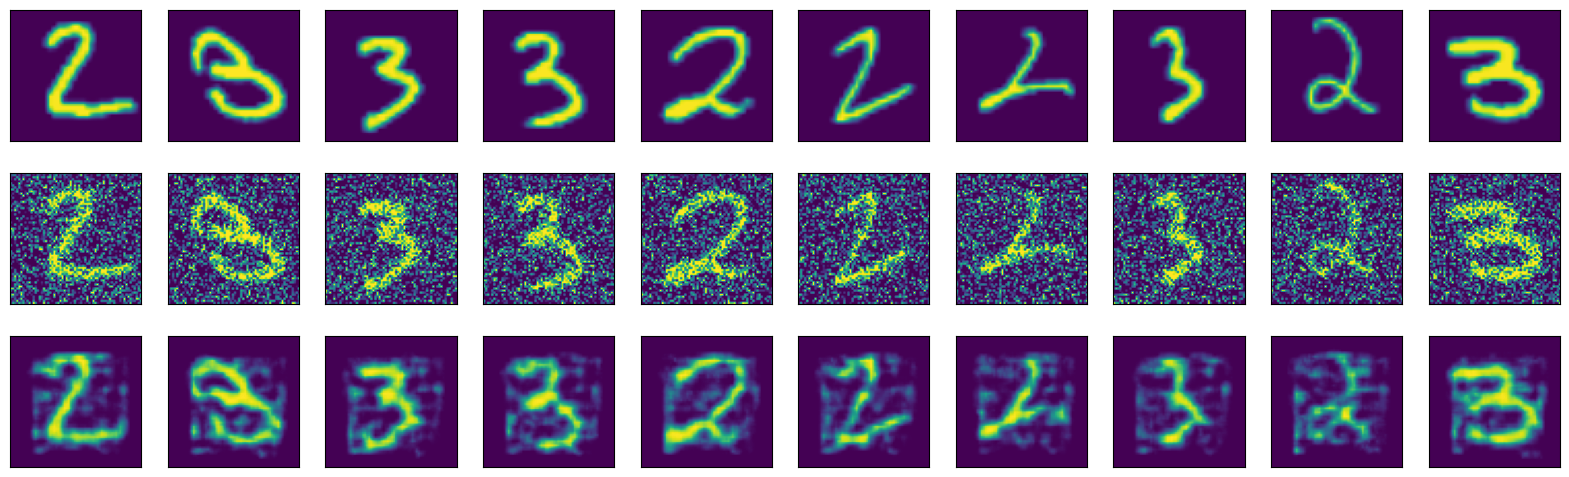

In [ ]:
# Test performance of reconstruction under Gaussian noise attack by using our model
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Gaussian noise attack function
def gaussian_noise_attack(data, std):
    noise = torch.randn_like(data) * std
    perturbed_data = data + noise
    perturbed_data = torch.clamp(perturbed_data, 0, 1)
    return perturbed_data

# Plot original images, Gaussian noise attacked images, and reconstructed Gaussian noise attacked images
def plot_images(original_images, perturbed_images, reconstructed_images, n=10):
    original_images = original_images.cpu().numpy()
    perturbed_images = perturbed_images.cpu().detach().numpy()
    reconstructed_images = reconstructed_images.cpu().detach().numpy()

    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Display original images
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(original_images[i].transpose(1, 2, 0).squeeze())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display Gaussian noise attacked images
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(perturbed_images[i].transpose(1, 2, 0).squeeze())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstructed Gaussian noise attacked images
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(reconstructed_images[i].transpose(1, 2, 0).squeeze())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Function to filter out only the digits 2 and 3
def filter_2_and_3(data, target):
    mask = (target == 2) | (target == 3)
    return data[mask], target[mask]

# Choose a random batch of images from the test dataset
data, targets = next(iter(test_loader))
data, targets = data.to(device), targets.to(device)

# Filter out only the digits 2 and 3
data, targets = filter_2_and_3(data, targets)

# Set Gaussian noise attack parameters
std = 0.5  # Noise standard deviation

# Generate adversarial samples using Gaussian noise
perturbed_data = gaussian_noise_attack(data, std)

# Reconstruct adversarial samples
recon_batch, _, _, _, _ = models[best_model_idx](perturbed_data)

# Plot original images, Gaussian noise attacked images, and reconstructed Gaussian noise attacked images
plot_images(data.cpu(), perturbed_data.cpu(), recon_batch.cpu())
